# **_Santander_ Customer Transaction Prediction**

## Workflow description
1. **Data exploration** - First look at the data to understand which are the most relevant information. General inspection techniques have been used.
3. **Data pre-processing** - Considering the high number of data, a pre-processing with the aim of removing usless information has been carried out.
4. **First model: Decision Tree** - A simple model has been used in order to obtain a baseline. Given the performance of this model, the following ones are tuned in order to improve the baseline performance 
5. **Second model: Gaussian Naive Bayes** - Slightly complex model used to improve the performance obtained so far
6. **Third model: k-Nearest Neighbor** - Slightly complex model used to improve the performance obtained so far
7. **Model comparison** - All models have been compared, using differnet sets of parameters, to see which one has obtained higher performances

## Import section

In [1]:
import warnings
warnings.filterwarnings('ignore') # uncomment this line to suppress warnings

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

## 1. Data exploration

There are two sets of data: `train.csv` and `test.csv`.
Since only `train.csv`is provided with the `target` column, the other dataset is not considered

In [2]:
train_url = '/kaggle/input/santander-customer-transaction-prediction/train.csv'
test_url = '/kaggle/input/santander-customer-transaction-prediction/test.csv'
target = 'target'
id_col = 'ID_code' 

random_state = 42
train_size = 0.80
np.random.seed(random_state)
cv = 3

train_df = pd.read_csv(train_url)
test_df = pd.read_csv(test_url)
comparison_df = pd.DataFrame(columns=['Scoring','Model name','Parameters', 'accuracy','precision_macro','recall_macro','f1_macro'])

In [3]:
print("TRAIN: There are {} rows and {} columns".format(train_df.shape[0],train_df.shape[1]))
print("TEST: There are {} rows and {} columns".format(test_df.shape[0],test_df.shape[1]))

TRAIN: There are 200000 rows and 202 columns
TEST: There are 200000 rows and 201 columns


The `target` column is binary and it indicates if a transaction is **fraudulent** or not.

In [4]:
train_df.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [5]:
train_df.describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.100490,10.679914,-1.627622,10.715192,6.796529,11.078333,-5.065317,5.408949,16.545850,0.284162,...,3.234440,7.438408,1.927839,3.331774,17.993784,-0.142088,2.303335,8.908158,15.870720,-3.326537
std,0.300653,3.040051,4.050044,2.640894,2.043319,1.623150,7.863267,0.866607,3.418076,3.332634,...,4.559922,3.023272,1.478423,3.992030,3.135162,1.429372,5.454369,0.921625,3.010945,10.438015
min,0.000000,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,-10.505500,...,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.261000,-14.209600,5.960600,6.299300,-38.852800
25%,0.000000,8.453850,-4.740025,8.722475,5.254075,9.883175,-11.200350,4.767700,13.943800,-2.317800,...,-0.058825,5.157400,0.889775,0.584600,15.629800,-1.170700,-1.946925,8.252800,13.829700,-11.208475
50%,0.000000,10.524750,-1.608050,10.580000,6.825000,11.108250,-4.833150,5.385100,16.456800,0.393700,...,3.203600,7.347750,1.901300,3.396350,17.957950,-0.172700,2.408900,8.888200,15.934050,-2.819550
75%,0.000000,12.758200,1.358625,12.516700,8.324100,12.261125,0.924800,6.003000,19.102900,2.937900,...,6.406200,9.512525,2.949500,6.205800,20.396525,0.829600,6.556725,9.593300,18.064725,4.836800
max,1.000000,20.315000,10.376800,19.353000,13.188300,16.671400,17.251600,8.447700,27.691800,10.151300,...,18.440900,16.716500,8.402400,18.281800,27.928800,4.272900,18.321500,12.000400,26.079100,28.500700


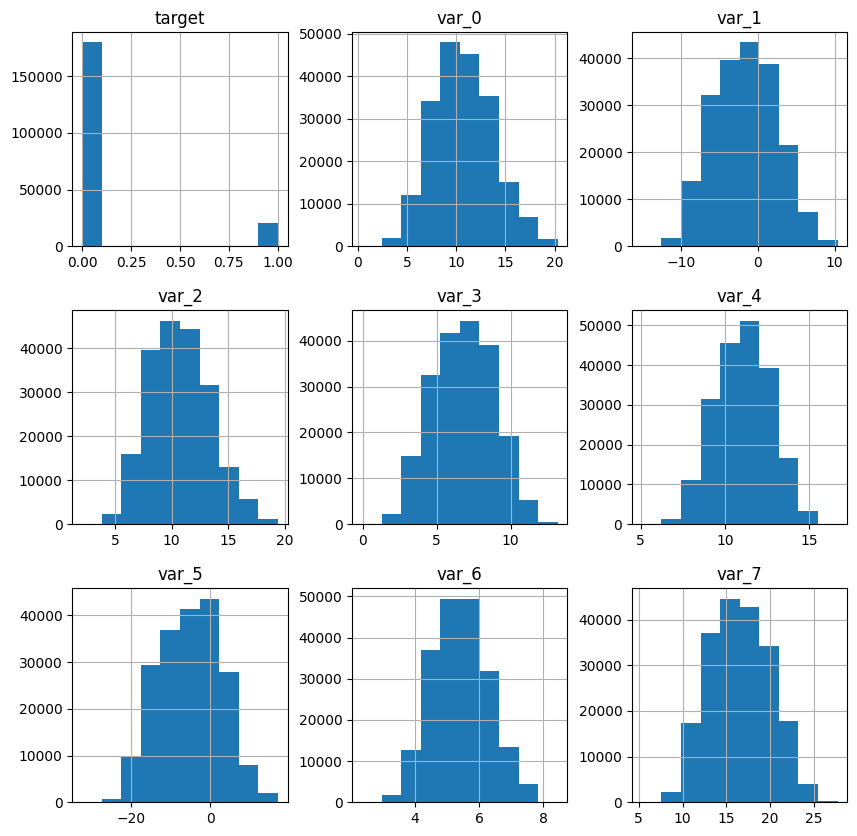

In [6]:
train_df[train_df.columns[0:10]].hist(figsize=(10,10));

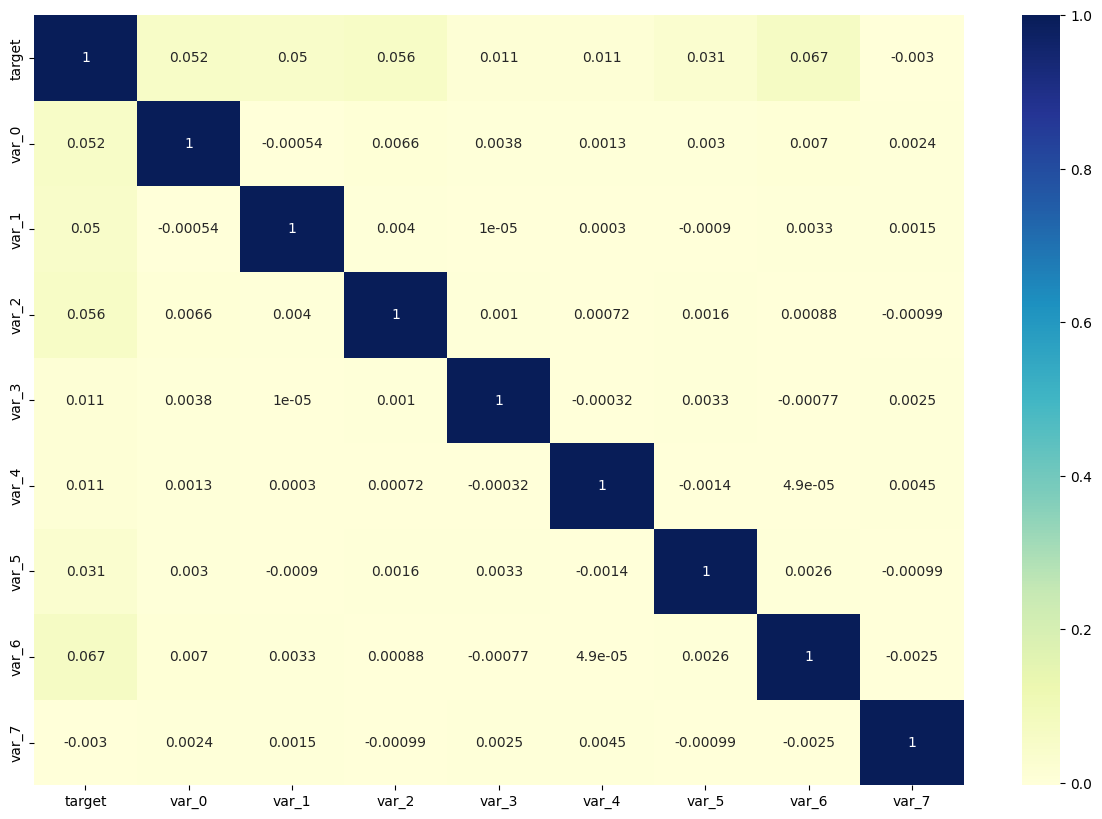

In [7]:
corr = train_df[train_df.columns[0:10]].corr(numeric_only=True)

plt.figure(figsize=(15,10)) # set X and Y size
sns.heatmap(corr, cmap="YlGnBu", annot=True);

## 2. Data pre-processing

Two pre-processing step have been done:
- The **index column**, called '`ID_code`', has been dropped since it is now usefull for the training of the model.
- All _**NaN**_ value have been dropped (if any).

In [8]:
train_df.drop(columns=[id_col], inplace=True)
train_df.isna().sum().unique() # no NaN value have been found

array([0])

## 3. Train-Test split

The data available are divided in the following way:
- 80% for **training**
- 20% for **testing**

In order to test all the different _**hyper-parameters configuration**_, during the first part of the **training**, only a subset of the complete dataset has been used. Once the **best _model_** and the **best _parameters_** have been found, a complete training is carried out.

In [9]:
n_samples = 200_000

X = train_df.drop(target, axis=1)
y = train_df[target]

X_small = X[:n_samples]
y_small = y[:n_samples]

X_train, X_test, y_train, y_test = train_test_split(X_small, y_small, random_state = random_state, train_size = train_size)

## 4. First model: **_DecisionTreeClassifier_**

In [10]:
model = DecisionTreeClassifier(criterion = 'entropy')

model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

The evaluation of the model is considered using different metrics:
- `accuracy`,`precision`,`recall`,`f1-score`

A **macro** average is used for computing the overall performance. By doing this, we are calculating first the metrics for each label, and then their unweighted mean. This does not take label imbalance into account.

In [11]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.91      0.91      0.91     35903
           1       0.19      0.19      0.19      4097

    accuracy                           0.83     40000
   macro avg       0.55      0.55      0.55     40000
weighted avg       0.83      0.83      0.83     40000



In [12]:
accuracy = accuracy_score(y_test, y_pred_test)
precision = precision_score(y_test, y_pred_test, average='macro')
recall = recall_score(y_test, y_pred_test, average='macro')
f1 = f1_score(y_test, y_pred_test, average='macro')

print("The accuracy on test set is {0:.2f}%".format(accuracy * 100))
print("The precision_macro on test set is {0:.2f}%".format(precision * 100))
print("The recall_macro on test set is {0:.2f}%".format(recall * 100))
print("The f1_macro on test set is {0:.2f}%".format(f1 * 100))


The accuracy on test set is 83.49%
The precision_macro on test set is 55.11%
The recall_macro on test set is 55.11%
The f1_macro on test set is 55.11%


## 5. Second model: **_Gaussian Naive Bayes_**

In [13]:
model = DecisionTreeClassifier()

model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

In [14]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.91      0.90      0.91     35903
           1       0.20      0.21      0.21      4097

    accuracy                           0.83     40000
   macro avg       0.56      0.56      0.56     40000
weighted avg       0.84      0.83      0.84     40000



In [15]:
accuracy = accuracy_score(y_test, y_pred_test)
precision = precision_score(y_test, y_pred_test, average='macro')
recall = recall_score(y_test, y_pred_test, average='macro')
f1 = f1_score(y_test, y_pred_test, average='macro')

print("The accuracy on test set is {0:.2f}%".format(accuracy * 100))
print("The precision_macro on test set is {0:.2f}%".format(precision * 100))
print("The recall_macro on test set is {0:.2f}%".format(recall * 100))
print("The f1_macro on test set is {0:.2f}%".format(f1 * 100))

The accuracy on test set is 83.39%
The precision_macro on test set is 55.67%
The recall_macro on test set is 55.91%
The f1_macro on test set is 55.78%


## 6. Third model: **_k-Nearest Neighbor_**


In [16]:
model = KNeighborsClassifier()

model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

In [17]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95     35903
           1       0.19      0.00      0.01      4097

    accuracy                           0.90     40000
   macro avg       0.55      0.50      0.48     40000
weighted avg       0.83      0.90      0.85     40000



In [18]:
accuracy = accuracy_score(y_test, y_pred_test)
precision = precision_score(y_test, y_pred_test, average='macro')
recall = recall_score(y_test, y_pred_test, average='macro')
f1 = f1_score(y_test, y_pred_test, average='macro')

print("The accuracy on test set is {0:.2f}%".format(accuracy * 100))
print("The precision_macro on test set is {0:.2f}%".format(precision * 100))
print("The recall_macro on test set is {0:.2f}%".format(recall * 100))
print("The f1_macro on test set is {0:.2f}%".format(f1 * 100))

The accuracy on test set is 89.66%
The precision_macro on test set is 54.56%
The recall_macro on test set is 50.08%
The f1_macro on test set is 47.56%


## 7. Model comparison

In [19]:
model_lbls = ['decision_tree', 'gaussian_nb','knn']

models = {
    'decision_tree': {'name': 'Decision Tree',
           'estimator': DecisionTreeClassifier(random_state=random_state), 
           'param': [{'max_depth': [*range(1,20)],'class_weight':[None,'balanced']}],
          },
    'gaussian_nb': {'name': 'Gaussian Naive Bayes',
           'estimator': GaussianNB(),
           'param': [{'var_smoothing': [10**exp for exp in range(-3,-13,-1)]}]
          },
    'knn':{'name': 'K Nearest Neighbor',
           'estimator': KNeighborsClassifier(),
           'param': [{'n_neighbors': list(range(1,7))}]
           },
}

scorings = ['accuracy','precision_macro','recall_macro','f1_macro']
clfs = []

In [20]:
for scoring in scorings:
    for m in model_lbls:
        clf = GridSearchCV(models[m]['estimator'], models[m]['param'], cv = cv, scoring = scoring)
        clf.fit(X_train, y_train)   
        clfs.append(clf)
        
        y_true, y_pred = y_test, clf.predict(X_test)

        cr = classification_report(y_true,y_pred, output_dict=True, zero_division=1)
        
        comparison_df.loc[len(comparison_df)] = [scoring, models[m]['name'], clf.best_params_,
                                     cr['accuracy'],
                                     cr['macro avg']['precision'],
                                     cr['macro avg']['recall'],
                                     cr['macro avg']['f1-score']]

In [21]:
comparison_df

,Scoring,Model name,Parameters,accuracy,precision_macro,recall_macro,f1_macro
0,accuracy,Decision Tree,"{'class_weight': None, 'max_depth': 3}",0.897625,0.712147,0.502190,0.477848
1,accuracy,Gaussian Naive Bayes,{'var_smoothing': 1e-06},0.920650,0.825632,0.676431,0.722528
2,accuracy,K Nearest Neighbor,{'n_neighbors': 6},0.897475,0.532126,0.500052,0.473227
3,precision_macro,Decision Tree,"{'class_weight': None, 'max_depth': 3}",0.897625,0.712147,0.502190,0.477848
4,precision_macro,Gaussian Naive Bayes,{'var_smoothing': 0.001},0.914500,0.868360,0.603271,0.645500
5,precision_macro,K Nearest Neighbor,{'n_neighbors': 6},0.897475,0.532126,0.500052,0.473227
6,recall_macro,Decision Tree,"{'class_weight': 'balanced', 'max_depth': 7}",0.701275,0.550504,0.615419,0.535566
7,recall_macro,Gaussian Naive Bayes,{'var_smoothing': 1e-09},0.920900,0.825864,0.678300,0.724298
8,recall_macro,K Nearest Neighbor,{'n_neighbors': 1},0.864825,0.526578,0.513001,0.511761
9,f1_macro,Decision Tree,"{'class_weight': None, 'max_depth': 19}",0.875600,0.597057,0.551546,0.562149


In [22]:
for score in scorings:
    scoring_filter = score
    display(comparison_df[comparison_df.Scoring==scoring_filter]\
                .sort_values(by=scoring_filter,ascending=False)\
                .drop('Scoring',axis=1)\
                .head(3)
    )

,Model name,Parameters,accuracy,precision_macro,recall_macro,f1_macro
1,Gaussian Naive Bayes,{'var_smoothing': 1e-06},0.920650,0.825632,0.676431,0.722528
0,Decision Tree,"{'class_weight': None, 'max_depth': 3}",0.897625,0.712147,0.502190,0.477848
2,K Nearest Neighbor,{'n_neighbors': 6},0.897475,0.532126,0.500052,0.473227


,Model name,Parameters,accuracy,precision_macro,recall_macro,f1_macro
4,Gaussian Naive Bayes,{'var_smoothing': 0.001},0.914500,0.868360,0.603271,0.645500
3,Decision Tree,"{'class_weight': None, 'max_depth': 3}",0.897625,0.712147,0.502190,0.477848
5,K Nearest Neighbor,{'n_neighbors': 6},0.897475,0.532126,0.500052,0.473227


,Model name,Parameters,accuracy,precision_macro,recall_macro,f1_macro
7,Gaussian Naive Bayes,{'var_smoothing': 1e-09},0.920900,0.825864,0.678300,0.724298
6,Decision Tree,"{'class_weight': 'balanced', 'max_depth': 7}",0.701275,0.550504,0.615419,0.535566
8,K Nearest Neighbor,{'n_neighbors': 1},0.864825,0.526578,0.513001,0.511761


,Model name,Parameters,accuracy,precision_macro,recall_macro,f1_macro
10,Gaussian Naive Bayes,{'var_smoothing': 1e-08},0.920825,0.825537,0.678042,0.723996
9,Decision Tree,"{'class_weight': None, 'max_depth': 19}",0.875600,0.597057,0.551546,0.562149
11,K Nearest Neighbor,{'n_neighbors': 1},0.864825,0.526578,0.513001,0.511761
